In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature

import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

OBS3 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4_ERA5_30km_WA_5-20N_new.p', 'rb'))

In [4]:
OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP25_ERA5_WA_5-20N.p', 'rb'))


In [5]:
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA5_5-20N.p', 'rb'))

In [6]:
OBS3.keys()

dict_keys(['hour', 'month', 'year', 'area', 'lon', 'lat', 'clon', 'clat', 'tmin', 'tmean', 'thetamean', 'thetamax', 'tmidmax', 'tmidmean', 'tsrfcmax', 'tsrfcmean', 'pmax', 'pmean', 'qmax', 'qmean', 'umax_srfc', 'umean_srfc', 'umin_mid', 'umean_mid', 'shearmin', 'shearmean', 'pgt30', 'pgt01isvalid', 't', 'p', 'q', 'u_srfc', 'u_mid', 'shear'])

In [7]:
np.unique(OBS2['year'])

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015])

In [9]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    qup = np.array(dic['q650'])
    tup = np.array(dic['t650'])
    tlow = np.array(dic['t925'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    
    
    pdub = np.array([650]*len(tlow))
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetae_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)
    
    thetae_down = u_met.theta_e(925, tlow-273.15, qq)
    
    thetae = thetae_down - thetae_up
    
    theta_up = u_met.theta(650, tup-273.15)
    theta_down = u_met.theta(925, tlow-273.15)
    
    theta = theta_down - theta_up

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        't650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'theta' : theta,
        'theta_e' : thetae,
        'thup' : thetae_up,
        'thdown' : thetae_down,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [10]:
def create_dic_model(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) 
    tup = np.array(dic['t'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    try:
        thetamax = np.array(dic['thetamax'])
        thetamean = np.array(dic['thetamean'])   
    except:
        pass

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area),#*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    
    try:
        obs_pcp['thetamax']=thetamax 
        obs_pcp['thetamean']=thetamean
    except:
        pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [11]:
obs_trmm = create_dic_model(OBS)
obs_gpm = create_dic(OBS2)
obs_40 = create_dic_model(OBS3)

In [12]:
np.max(obs_gpm.lat)

17.74562661158754

In [13]:
obs_gpm.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'q650', 't925', 't650', 'shear',
       'month', 'area', 'tmin', 'tmean', 'theta', 'theta_e', 'thup', 'thdown',
       'lat', 'lon'],
      dtype='object')

In [14]:
obs_trmm = obs_trmm[obs_trmm['tmin']>-105]

In [15]:
obs_gpm.theta_e

0        2.392802
1       -0.977916
2       -5.102126
3       -2.892242
4        1.193396
           ...   
51956    3.105751
51957    2.732607
51958   -0.307899
51959   -8.041905
51960   -1.270154
Name: theta_e, Length: 51961, dtype: float64

In [16]:
obs_trmm = obs_trmm[(obs_trmm.lon>=-12)&(obs_trmm.lon<=12)&(obs_trmm.lat>=8.5)&(obs_trmm.lat<=19)& (obs_trmm.month>=2) & (obs_trmm.month<=11)]  #5.2 - 8.3
obs_gpm = obs_gpm[(obs_gpm.lon>=-12)&(obs_gpm.lon<=12)&(obs_gpm.lat>=8.5)&(obs_gpm.lat<=19)& (obs_gpm.month>=2) & (obs_gpm.month<=11)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
obs_40 = obs_40[(obs_40.lon>=-12)&(obs_40.lon<=12)&(obs_40.lat>=8.5)&(obs_40.lat<=19)& (obs_40.month>=2) & (obs_40.month<=11)]


In [17]:
dss = [obs_trmm, obs_40]
for dataset in dss:
    mask = (np.isfinite(dataset['prcp']))
    for k in dataset.keys():
        dataset[k] = (dataset[k])[mask]

In [18]:
print('OBS_40', obs_40.lat.min(), obs_40.lat.max(), obs_40.lon.min(), obs_40.lon.max())
print('OBS_trmm', obs_trmm.lat.min(), obs_trmm.lat.max(), obs_trmm.lon.min(), obs_trmm.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

OBS_40 8.502001523971558 18.97125244140625 -11.76275634765625 11.76776123046875
OBS_trmm 8.502001762390137 18.991501808166504 -11.580490112304688 11.544998168945312
OBS_gpm 8.50007155018848 17.74562661158754 -11.998787551565622 11.996942654145766


In [19]:
obs_trmm.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'shear', 'month', 'area', 'tmin',
       'tmean', 'lat', 'lon'],
      dtype='object')

Text(0.5,1,'-0.41')

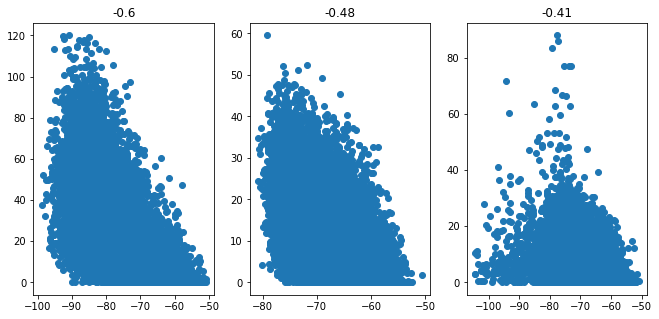

In [20]:
obss = [obs_trmm.tmin, obs_trmm.prcp] # p25
cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [obs_40.tmin, obs_40.prcp] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)


Text(0.5,1,'0.33')

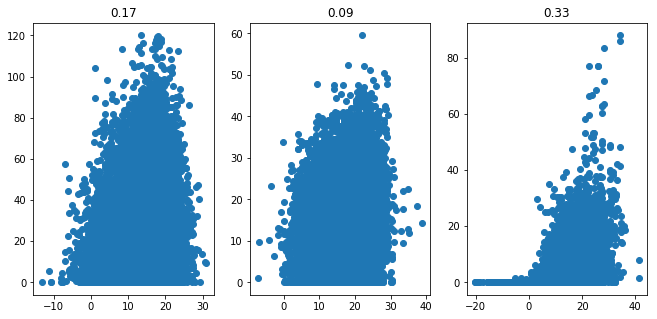

In [21]:
obss = [obs_trmm.shear, obs_trmm.prcp] # p25
cp4s = [obs_gpm.shear, obs_gpm.prcp] # gpm
cp25s = [obs_40.shear, obs_40.prcp] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

(array([  36.,   35.,   54.,  500., 1136.,  887.,  641.,  565.,  436.,
         396.]),
 array([ 58. , 112.2, 166.4, 220.6, 274.8, 329. , 383.2, 437.4, 491.6,
        545.8, 600. ]),
 <a list of 10 Patch objects>)

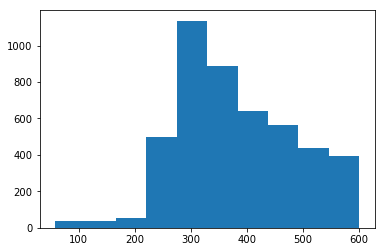

In [22]:
plt.hist(obs_trmm.area, range=[58,600])

(8, 19)

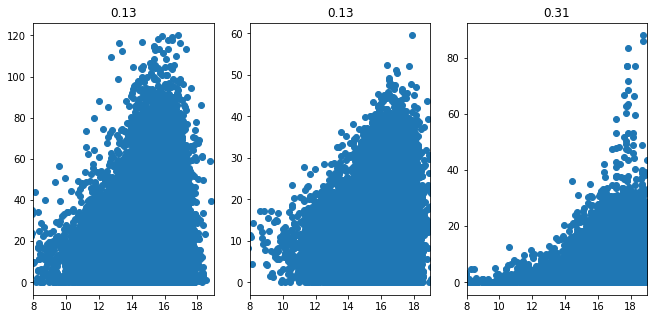

In [23]:
obss = [obs_trmm.q925, obs_trmm.prcp] # p25
cp4s = [obs_gpm.q925, obs_gpm.prcp] # gpm
cp25s = [obs_40.q925, obs_40.prcp] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))
ax.set_xlim(8,19)

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)
ax.set_xlim(8,19)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
ax.set_xlim(8,19)
#ax.set_ylim(13,19)


(-0.04658399892001153, 4.861626519541546e-16)


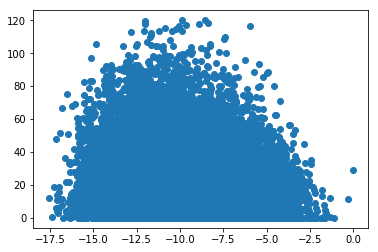

In [24]:
v1=obs_gpm.theta#.thdown-obs_gpm.thup
v2=obs_gpm.prcp
plt.scatter(v1, v2)
r = stats.pearsonr(v1,v2)
print(r)

Text(0.5,1,'0.33')

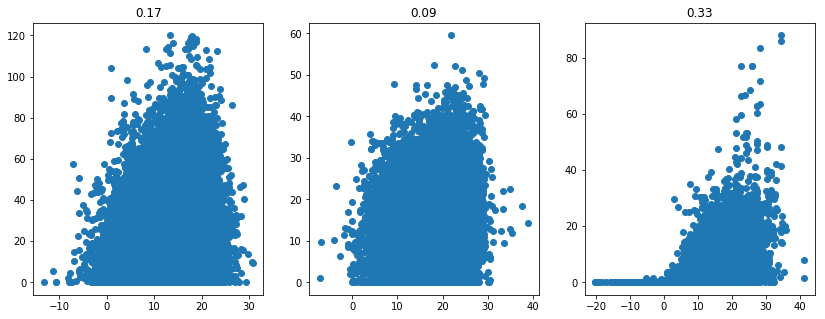

In [25]:
obss = [obs_trmm.shear, obs_trmm.prcp] # p25
cp4s = [obs_gpm.shear, obs_gpm.prcp] # gpm
cp25s = [obs_40.shear, obs_40.prcp] #cp4


f = plt.figure(figsize=(14,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

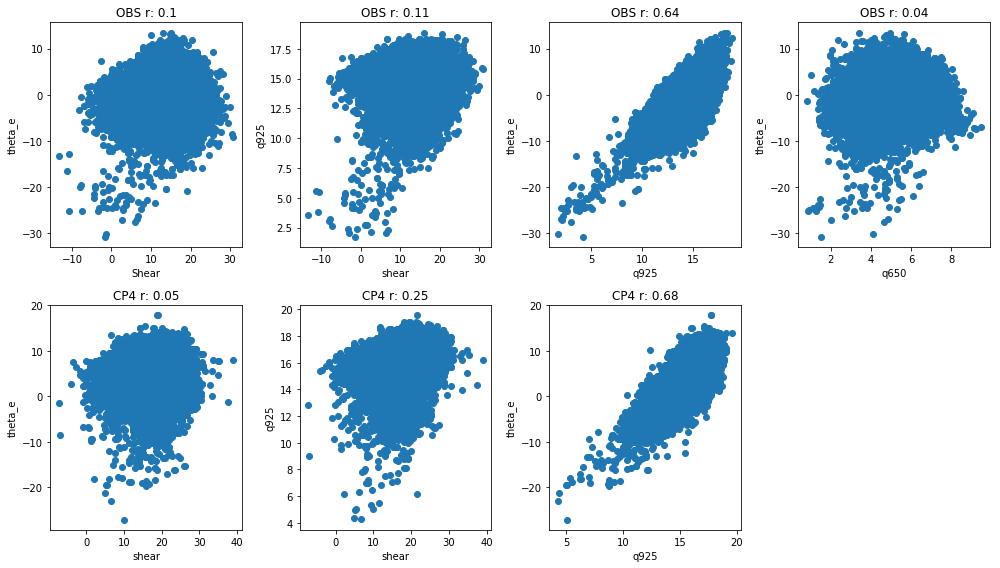

In [26]:
obss = [obs_40.shear, obs_40.thetamax, obs_40.q925, obs_40.tmin, obs_40.prcp] # cp4
cp4s = [obs_gpm.shear, obs_gpm.theta_e, obs_gpm.q925, obs_gpm.tmin, obs_gpm.prcp, obs_gpm.q650,  obs_gpm.t650]  # gpm



f = plt.figure(figsize=(14,8))
ax = f.add_subplot(241)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Shear')
plt.ylabel('theta_e')

ax = f.add_subplot(242)
r = stats.pearsonr(cp4s[0],cp4s[2])
plt.scatter(cp4s[0],cp4s[2])
plt.title('OBS r: '+ str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('q925')

ax = f.add_subplot(243)
r = stats.pearsonr(cp4s[2],cp4s[1])
plt.scatter(cp4s[2],cp4s[1])
plt.title('OBS r: '+ str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('theta_e')

ax = f.add_subplot(244)
r = stats.pearsonr(cp4s[5],cp4s[1])
plt.scatter(cp4s[5],cp4s[1])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('q650')
plt.ylabel('theta_e')


ax = f.add_subplot(245)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('theta_e')

ax = f.add_subplot(246)
plt.scatter(obss[0],obss[2])
r = stats.pearsonr(obss[0],obss[2])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('q925')

ax = f.add_subplot(247)
plt.scatter(obss[2],obss[1])
r = stats.pearsonr(obss[2],obss[1])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('theta_e')

# ax = f.add_subplot(248)
# r = stats.pearsonr(cp4s[6],cp4s[1])
# plt.scatter(cp4s[6],cp4s[1])
# plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
# plt.xlabel('t650')
# plt.ylabel('theta_e')

plt.tight_layout()
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

plt.savefig(cnst.network_data + 'figs/CLOVER/scatter_SoudanoSahel_OBS_CP4.png')

Text(0.5,1,'0.68')

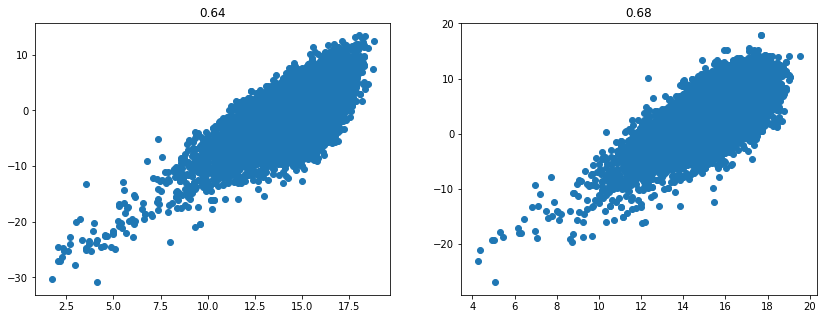

In [27]:
obss = [obs_40.q925, obs_40.thetamax] # cp4
cp4s = [obs_gpm.q925, obs_gpm.theta_e] # gpm



f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))



ax = f.add_subplot(122)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

pears (0.06928622160651544, 1.3873866951876583e-33)
pears (0.12095169316888653, 4.248939473733988e-104)


Text(0.5,1,'CP4: 0.12')

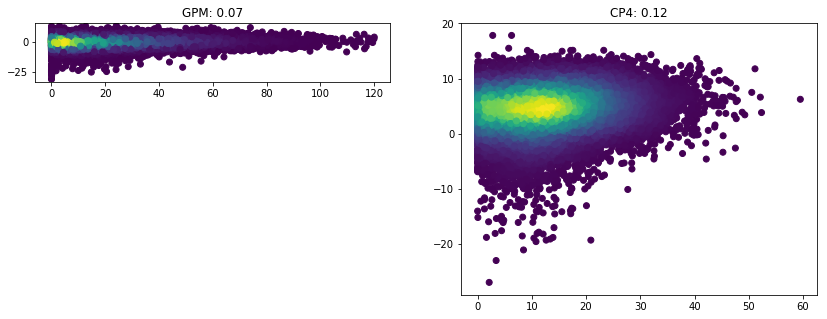

In [28]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())
    r = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

obss = [obs_40.prcp, obs_40.thetamax, obs_40.q925] # cp4
cp4s = [obs_gpm.prcp, obs_gpm.theta_e, obs_40.q925] # gpm



f = plt.figure(figsize=(14,5))
ax = f.add_subplot(421)
data, r = density_plot(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1], c=data)
plt.title('GPM: ' + str(np.round(r[0], decimals=2)))


ax = f.add_subplot(122)
data, r = density_plot(obss[0],obss[1])
plt.scatter(obss[0],obss[1], c=data)

plt.title('CP4: ' + str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

(9588,) (9588,) (9588,)


Text(0.5,1,'0.33')

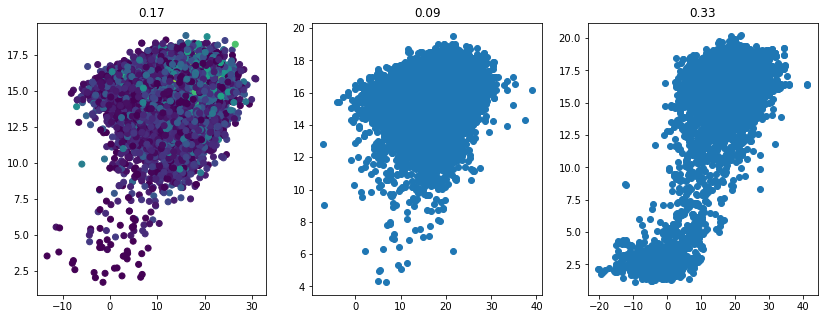

In [47]:
obss = [obs_trmm.shear, obs_trmm.prcp, obs_trmm.q925] # p25
cp4s = [obs_gpm.shear, obs_gpm.prcp, obs_gpm.q925] # gpm
cp25s = [obs_40.shear, obs_40.prcp, obs_40.q925] #cp4


f = plt.figure(figsize=(14,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[2], c=cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

cp25s[0] = cp25s[0][np.isfinite(cp25s[1])]
cp25s[1] = cp25s[1][np.isfinite(cp25s[1])]
cp25s[2] = cp25s[2][np.isfinite(cp25s[1])]

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[2])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

obss[0] = obss[0][np.isfinite(obss[1])]
obss[1] = obss[1][np.isfinite(obss[1])]
obss[2] = obss[2][np.isfinite(obss[1])]

print(obss[0].shape, obss[2].shape, obss[1].shape)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[2])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

In [48]:
tl = []
for m in range(2,12):
    try:
        dat = obs_trmm[(obs_trmm.month==m)]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 75)
    except:
        continue
    print(m,out)
    tl.append(out)

3 14.025568721488636
4 13.184980454866787
5 13.050241205189117
6 12.864217608835133
7 12.633995607332055
8 14.453265273218134
9 13.660595697577946
10 12.725892043172724
11 14.021799505334958


In [49]:
pl = []
for m in range(2,12):
    try:
        dat = obs_gpm[obs_gpm.month==m]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 98)
    except:
        continue
    print(m,out)
    pl.append(out)

3 52.522384304289616
4 53.594468662226696
5 61.374012557362335
6 75.09174454325213
7 72.7035383081436
8 74.94971359102382
9 72.09129853466439
10 61.697360286335595
11 46.735812982075316


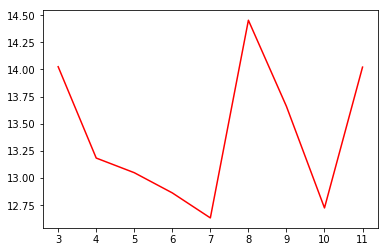

In [50]:
#plt.plot(np.arange(3,12), pl)
plt.plot(np.arange(3,12), tl, 'r')

In [51]:
print(obs_trmm.area.min())
print(obs_gpm.area.min())
print(obs_40.area.min())

3
5150
3


In [52]:
ptrmm = []
pgpm = []
ptrmm40 = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[(obs_trmm.month == m) & (obs_trmm.prcp>1)],95))
    pgpm.append(np.percentile(obs_gpm.prcp[(obs_gpm.month == m) & (obs_gpm.prcp>1)],95))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[(obs_40.month == m) & (obs_40.prcp>1),95]))
    except:
        ptrmm40.append(np.nan)

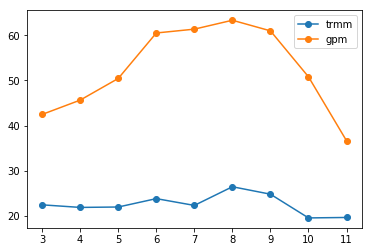

In [53]:
plt.figure()
plt.plot(range(3,12), ptrmm, '-o', label='trmm')
plt.plot(range(3,12), pgpm, '-o',label='gpm')
#plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

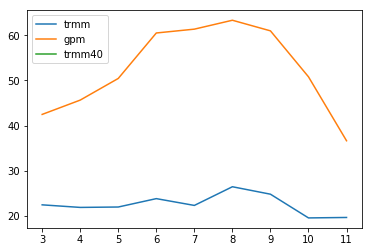

In [54]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')

plt.legend()

In [55]:
ptrmm = []
pgpm = []
ptrmm40 = []
gridsat = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[obs_trmm.month == m],99))
    pgpm.append(np.percentile(obs_gpm.prcp[obs_gpm.month == m],99))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[obs_40.month == m],99))
    except:
        ptrmm40.append(np.nan)

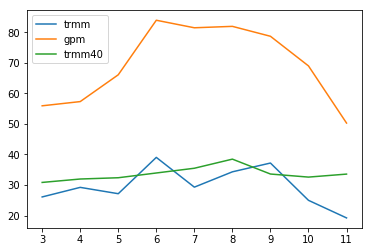

In [56]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

3 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
4 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
5 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
6 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
7 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
8 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
9 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
10 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
11 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
3 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>
4 <module 'numpy' from '/home/ck/miniconda3/lib/python3.7/site-packages/numpy/

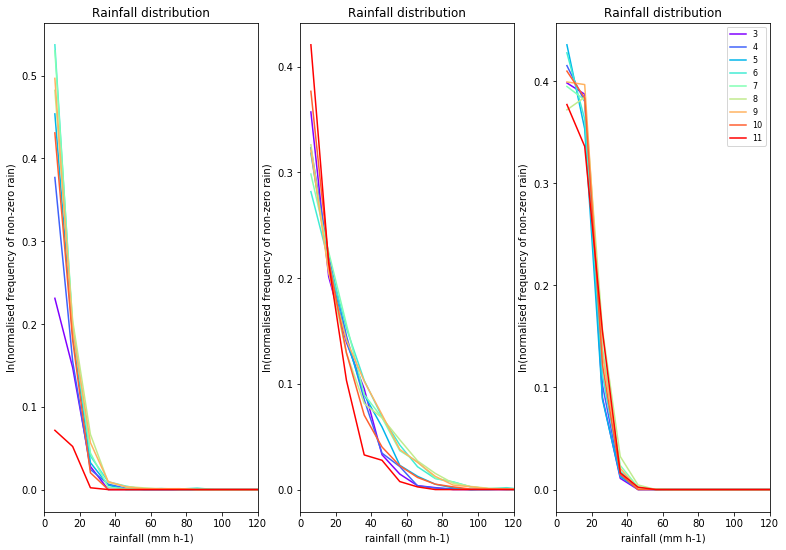

In [57]:
f = plt.figure(figsize=(13,9))

for ids, data in enumerate([obs_trmm, obs_gpm, obs_40]):
    #ipdb.set_trace()
    ax = f.add_subplot(1,3,ids+1)
    colors = cm.rainbow(np.linspace(0,1,9))
    for m,c in zip(np.arange(3,12),colors):
        #print(m)
        
        monthly = (data['prcp'])[data['month'] == m]

        print(m, np)

        #ipdb.set_trace()
        weights = np.ones_like(monthly) / float(len(monthly))
        hist, h = np.histogram(monthly, bins=np.arange(1,201+1,10),  range=(1,201), weights=weights)
        #print(np.arange(20,120+1,10))
        bins=np.arange(1,201+1,10)
        #line, = ax.semilogy(hist, color=c, lw=2, label=str(m))
        mid = bins[1::]-5
        ax.plot(mid,hist, color=c, label=str(m))
    plt.ylabel('ln(normalised frequency of non-zero rain)')
    plt.xlim((0,120))
    plt.xlabel('rainfall (mm h-1)')
    
    plt.title('Rainfall distribution')

plt.legend(fontsize=8)


In [196]:
oposi = (obs_gpm.q925>=10.9) & (obs_gpm.shear>0) &  (obs_gpm.prcp>=5)# & ((obs_gpm.month>=9) | (obs_gpm.month<=5))
cposi = (obs_40.q925>=10.9) & (obs_40.shear>0) &  (obs_40.prcp>=5) & (np.isfinite(obs_40.q925)) & (np.isfinite(obs_40.shear)  & (obs_40.area>=258))
pposi = (obs_trmm.q925>=10.9) &(obs_trmm.shear>0) &  (obs_trmm.prcp>=3) & (np.isfinite(obs_trmm.q925)) & (np.isfinite(obs_trmm.shear))

In [197]:
obsp = obs_gpm[oposi]
cp4 = obs_40[cposi]
cp4.area = cp4.area.values*(4.4**2)
p25 = obs_trmm[pposi]

In [198]:
cp4.area.min()

4994.880000000001

In [199]:
obsp.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'q650', 't925', 't650', 'shear',
       'month', 'area', 'tmin', 'tmean', 'theta', 'theta_e', 'thup', 'thdown',
       'lat', 'lon'],
      dtype='object')

In [200]:
len(obsp)

22142

In [201]:
len(p25)

5353

In [202]:
len(cp4)

24216

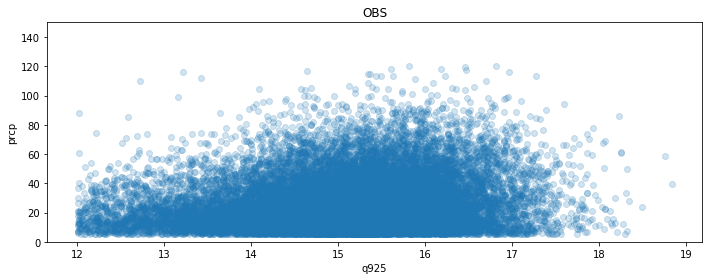

In [203]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).q925, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

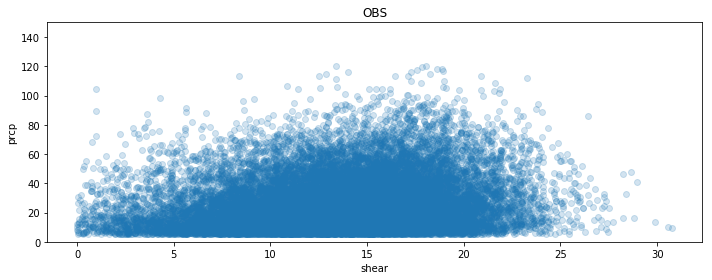

In [204]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).shear, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('shear')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

In [205]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    rr = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

In [206]:
print(obsp['q925'].median())
print(obsp['shear'].median())
print(obsp['prcp'].median())
print(obsp['tmin'].median())
print(obsp['theta_e'].median())

15.126557555049658
13.851145267486572
21.158971734106302
-79.7136857308513
-0.1559032914983618


In [207]:
print(obsp['q925'].mean())
print(obsp['shear'].mean())
print(obsp['prcp'].mean())
print(obsp['tmin'].mean())
print(obsp['theta_e'].mean())

14.987341527872594
13.546965490699234
26.060764486049372
-79.17044176082534
-0.15668817559744166


In [208]:
nbqq = 9
nbss = 9

p1 = 1.2#1.2#1.2
p2 = 98.8 #98.8


qbinso = np.linspace(np.percentile(obsp.q925,p1) , np.percentile(obsp.q925, p2), nbqq)
shear_obsp = np.linspace(np.percentile(obsp.shear, p1) , np.percentile(obsp.shear, p2), nbss)
theta_obsp = np.linspace(np.percentile(obsp.theta_e, p1) , np.percentile(obsp.theta_e, p2), nbss)

q4 = np.linspace(np.percentile(cp4.q925,p1) , np.percentile(cp4.q925, p2), nbqq)
shear4 = np.linspace(np.percentile(cp4.shear, p1) , np.percentile(cp4.shear, p2), nbss)
theta4 = np.linspace(np.percentile(cp4.thetamax, p1) , np.percentile(cp4.thetamax, p2), nbss)

q25 = np.linspace(np.percentile(p25.q925,p1) , np.percentile(p25.q925, p2), nbqq)
shear25 = np.linspace(np.percentile(p25.shear, p1) , np.percentile(p25.shear, p2), nbss)

In [209]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.nanmean(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.nanmean(ds.prcp[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
            except:
                prcp_mean = np.nan
                
            try:
                ds_amean = np.nanmean(ds.area[poss_ds])
            except IndexError:
                ds_amean = np.nan
            
            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outval, outarea_ds,

In [210]:
def create_2dhist_theta(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    if 'theta_e' in ds.keys():
        tvar = 'theta_e'
    else:
        tvar = 'thetamax'
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds[tvar]>=qql) & (ds[tvar] < ybins[isq+1])
          
            try:
                ds_mean = np.nanmean(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.nanmean(ds.prcp[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
            except:
                prcp_mean = np.nan

            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp,  outval

In [211]:
def create_2dhist_q(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    if 'theta_e' in ds.keys():
        tvar = 'theta_e'
    else:
        tvar = 'thetamax'
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds[tvar] >= shl) & (ds[tvar] < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.nanmean(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.nanmean(ds.prcp[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
            except:
                prcp_mean = np.nan

            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outval

In [212]:
def hist2d_plot(data,xbins, ybins, vmin, vmax, valid=None):
    f = plt.figure()
    ax5 = f.add_subplot(111)
    X, Y = np.meshgrid(xbins,ybins)
    cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
    if valid is not None:
        data[valid<10] = np.nan
    Zm = ma.masked_where(np.isnan(data),data)

    mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=vmin, vmax=vmax) # viridis_rvmin=20, vmax=40
    #mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp) # viridis_rvmin=20, vmax=40

    ax5.set_ylabel('Max. q925hPa')
    ax5.set_xlabel('Max. u925hPa (equally populated)')
    ax5.set_title('')
    cbar = f.colorbar(mappable, ticks=np.linspace(vmin,vmax,9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label('90th centile max. rain')
    plt.show()

In [213]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    
    for i, dat in enumerate(data):
        if (i==2) | (i==3):
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
            
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<8] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_SoudanoSahel_25km_thetae_shear.png')

In [214]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        
        print(i)
        ax = f.add_subplot(2,3,i+1)
        if i>2:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_allWA_30km.png')

In [215]:
def hist2d_six_area(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        
        print(i)
        ax = f.add_subplot(2,3,i+1)
        if i in [0,1]:
            cmap = 'Reds_r'
            
        if i in [3,4]:
            cmap = 'Blues'
        if i in[2,5]:
            cmap = 'Purples'
            
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_SoudanoSahel_25km.png')

In [216]:
def hist2d_two(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(12,5))
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<15] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)

    plt.tight_layout() 
  #  plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_obsOnly.png')

In [217]:
cpobsperc, pcobs,  obsval, pcarea = create_2dhist(obsp, shear_obsp, qbinso)

In [218]:
tobsperc, tobs,  tval = create_2dhist_theta(obsp, shear_obsp, theta_obsp)

In [219]:
qtobsperc, qtobs,  qtval = create_2dhist_q(obsp, theta_obsp, qbinso)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


In [220]:
tt4, pc4,  val4, area4 = create_2dhist(cp4, shear4, q4)

In [221]:
thtt4, thpc4,  thval4 = create_2dhist_theta(cp4, shear4, theta4)

In [222]:
qttt4, qtpc4,  qtval4 = create_2dhist_q(cp4, theta4, q4)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


In [223]:
cp4.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'shear', 'month', 'area', 'tmin',
       'tmean', 'lat', 'lon', 'thetamax', 'thetamean'],
      dtype='object')

In [224]:
np.sum(np.isnan(cp4.shear))

0

In [225]:
tt25, pc25, val25,area25 = create_2dhist(p25, shear25, q25)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


In [226]:
p1 = 1#2
p2 = 99#99
p1t = 1#3
p2t = 99#98

In [227]:
vmin = np.percentile(tobsperc[(tobsperc!=0) & np.isfinite(tobsperc)],p1t)
vmax = np.percentile(tobsperc[(tobsperc!=0) & np.isfinite(tobsperc)],p2t)

thetatmin_dic_obs = {
    'data' : tobsperc,
    'ybins' : theta_obsp,
    'xbins' : shear_obsp,
    'title' : 'OBS: minimum temperature',
    'valid' : tval,
    'cbarlabel' : '${\circ}$C',
    'vmin' : vmin, #np.percentile(tobsperc[(tobsperc!=0) & np.isfinite(tobsperc)],p1t),
    'vmax' : vmax, #np.percentile(tobsperc[(tobsperc!=0) & np.isfinite(tobsperc)],p2t),
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

qtmin_dic_obs = {
    'data' : qtobsperc,
    'ybins' : qbinso,
    'xbins' : theta_obsp,
    'title' : 'OBS: minimum temperature',
    'valid' : obsval,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(qtobsperc[(qtobsperc!=0) & np.isfinite(qtobsperc)],p1t),
    'vmax' : np.percentile(qtobsperc[(qtobsperc!=0) & np.isfinite(qtobsperc)],p2t),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : r'$\Delta \theta _{e-es}$ (K)'
}

tmin_dic_obs = {
    'data' : cpobsperc,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'OBS: minimum temperature',
    'valid' : obsval,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],p1t),
    'vmax' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],p2t),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

vmin =  np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],p1)
vmax = np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],p2)

pcobs[pcobs==0]=np.nan
prcp_dic_obs = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'OBS: maximum precipitation',
    'valid' : obsval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : vmin, # np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],p1),
    'vmax' : vmax, #np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],p2),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

area_dic = {
    'data' : pcarea,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'OBS: MCS area',
    'valid' : obsval,
    'cbarlabel' : r'km$^{2}$',
    'vmin' : np.percentile(pcarea[(pcarea!=0) & np.isfinite(pcarea)],1),
    'vmax' : np.percentile(pcarea[(pcarea!=0) & np.isfinite(pcarea)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-2}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

tobs[tobs==0]=np.nan
thetaprcp_dic_obs = {
    'data' : tobs,
    'ybins' : theta_obsp,
    'xbins' : shear_obsp,
    'title' : 'OBS: maximum precipitation',
    'valid' : tval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(tobs[(tobs!=0) & np.isfinite(tobs)],p1),
    'vmax' : np.percentile(tobs[(tobs!=0) & np.isfinite(tobs)],p2),
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

qtobs[qtobs==0]=np.nan
qtprcp_dic_obs = {
    'data' : qtobs,
    'ybins' : qbinso,
    'xbins' : theta_obsp,
    'title' : 'OBS: maximum precipitation',
    'valid' : qtval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' :np.percentile(qtobs[(qtobs!=0) & np.isfinite(qtobs)],p1),
    'vmax' : np.percentile(qtobs[(qtobs!=0) & np.isfinite(qtobs)],p2),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : r'$\Delta \theta _{e-es}$ (K)'
}


In [228]:

############T: q shear
data = tt4

vmin = np.percentile(data[(data!=0) & np.isfinite(data)],p1t)
vmax = np.percentile(data[(data!=0) & np.isfinite(data)],p2t)

tmin_dic_cp4 = {
    
    'data' : data,
    'ybins' : q4,
    'xbins' : shear4,
#     'ybins' : qbinso,
#     'xbins' : shear_obsp,
    'title' : 'CP4: minimum temperature',
    'valid' : val4,
    'cbarlabel' : '${\circ}$C',
    'vmin' : vmin , #np.percentile(data[(data!=0) & np.isfinite(data)],p1t),
    'vmax' : vmax, #np.percentile(data[(data!=0) & np.isfinite(data)],p2t),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

############Area: q shear
data = area4
area_dic_cp4 = {
    
    'data' : data,
    'ybins' : q4,
    'xbins' : shear4,
#     'ybins' : qbinso,
#     'xbins' : shear_obsp,
    'title' : 'CP4: MCS area',
    'valid' : val4,
    'cbarlabel' : r'km$^{2}$',
    'vmin' : np.percentile(data[(data!=0) & np.isfinite(data)],p1t),
    'vmax' : np.percentile(data[(data!=0) & np.isfinite(data)],p2t),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

#######T: theta shear
data = thtt4
thetatmin_dic_cp4 = {
    
    'data' : data,
    'ybins' : theta4,
    'xbins' : shear4,
#     'ybins' : theta_obsp,
#     'xbins' : shear_obsp,
    'title' : 'CP4: minimum temperature',
    'valid' : val4,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(data[(data!=0) & np.isfinite(data)],p1t),
    'vmax' : np.percentile(data[(data!=0) & np.isfinite(data)],p2t),
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


############T: q theta
data = qttt4
qtmin_dic_cp4 = {
    
    'data' : data,
    'ybins' : q4,
    'xbins' : theta4,
#     'ybins' : qbinso,
#     'xbins' : theta_obsp,
    'title' : 'CP4: minimum temperature',
    'valid' : qtval4,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(data[(data!=0) & np.isfinite(data)],p1t),
    'vmax' : np.percentile(data[(data!=0) & np.isfinite(data)],p2t),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : r'$\Delta \theta _{e-es}$ (K)'
}


############Precip: q shear
pc4[pc4==0]=np.nan
data = pc4

vmin = np.percentile(data[(data!=0) & np.isfinite(data)],p1)
vmax = np.percentile(data[(data!=0) & np.isfinite(data)],p2)

prcp_dic_cp4 = {
    'data' : data,
    'ybins' : q4,
    'xbins' : shear4,
#     'ybins' : qbinso,
#     'xbins' : shear_obsp,
    'title' : 'CP4: maximum precipitation',
    'valid' : val4,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : vmin, #np.percentile(data[(data!=0) & np.isfinite(data)],p1), #1
    'vmax' : vmax, #np.percentile(data[(data!=0) & np.isfinite(data)],p2), #97
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


############Precip: q theta
qtpc4[qtpc4==0]=np.nan
data = qtpc4
qtprcp_dic_cp4 = {
    'data' : data,
#     'ybins' : qbinso,
#     'xbins' : theta_obsp,
    'ybins' : q4,
    'xbins' : theta4,
    'title' : 'CP4: maximum precipitation',
    'valid' : qtval4,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(data[(data!=0) & np.isfinite(data)],p1), #1
    'vmax' : np.percentile(data[(data!=0) & np.isfinite(data)],p2), #97
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : r'$\Delta \theta _{e-es}$ (K)'
}


############Precip: theta shear
thpc4[thpc4==0]=np.nan
data = thpc4

thetaprcp_dic_cp4 = {
    'data' : data,
    'ybins' : theta4,
    'xbins' : shear4,
#     'ybins' : theta_obsp,
#     'xbins' : shear_obsp,
    'title' : 'CP4: maximum precipitation',
    'valid' : thval4,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(data[(data!=0) & np.isfinite(data)],p1),
    'vmax' : np.percentile(data[(data!=0) & np.isfinite(data)],p2),
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

In [229]:
data = tt25

tmin_dic_p25 = {
    
    'data' : data,
    'ybins' : q25,
    'xbins' : shear25,
    'title' : 'P25: minimum temperature',
    'valid' : val25,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(data[(data!=0) & np.isfinite(data)],p1t),
    'vmax' : np.percentile(data[(data!=0) & np.isfinite(data)],97),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

pc25[pc25==0]=np.nan
data = pc25
prcp_dic_p25 = {
    'data' : data,
    'ybins' : q25,
    'xbins' : shear25,
    'title' : 'P25: maximum precipitation',
    'valid' : val25,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(data[(data!=0) & np.isfinite(data)],p1),
    'vmax' : np.percentile(data[(data!=0) & np.isfinite(data)],p2),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


In [230]:
shearscat = np.repeat(shear_obsp,pcobs.shape[0],axis=0).reshape(pcobs.shape)

In [231]:
deltaPS = []
deltaQPS = []
sboxplot = []
tminbox = []
for sh in np.unique(shearscat):
        
        vals = pcobs[sh==shearscat]
        tvals = cpobsperc[sh==shearscat]
        deltaPS.append(np.nanmax(vals)-np.nanmin(vals))
        try:
            deltaQPS.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
        except:
            deltaQPS.append(np.nan)
        sboxplot.append(vals)
        tminbox.append(tvals)
print(np.median(np.array(deltaQPS)[np.isfinite(np.array(deltaQPS))]))

5.356005989770221


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':


9
9


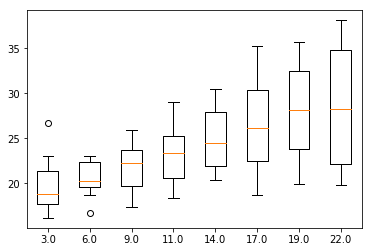

In [232]:
scoll = []
scollbins = np.round(np.unique(shearscat),2)
scollbins = np.round(scollbins[0:-1]+((scollbins[1::]-scollbins[0:-1])/2),0)
for b in sboxplot:
    scoll.append(b[np.isfinite(b)])
print(len(scoll))
print(len(np.unique(shearscat)))
ax = plt.boxplot(scoll[0:-1], labels=scollbins, whis=1)
box1= (scoll[0:-1],scollbins)

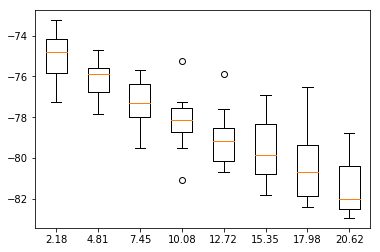

In [233]:
coll = []
for b in tminbox:
    coll.append(b[b!=0])
ax = plt.boxplot(coll[0:-1], labels=np.round(np.unique(shearscat),2)[0:-1])

0.5129639336519279
0.5793226588128522


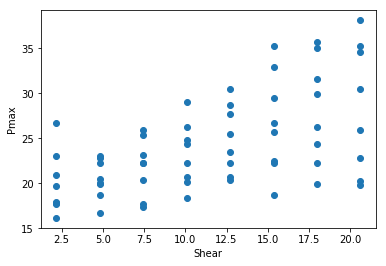

In [234]:
plt.scatter(shearscat, pcobs)
plt.xlabel('Shear')
plt.ylabel('Pmax')
shearfin = shearscat[np.isfinite(pcobs)]
pfin = pcobs[np.isfinite(pcobs)]
slope, intercept, r_value, p_value, std_err = stats.linregress(shearfin, pfin)
print(slope)
print(r_value)

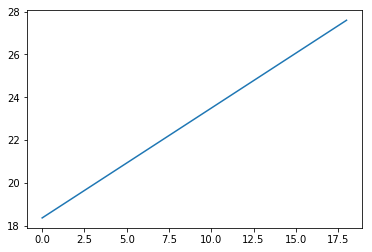

In [235]:
plt.plot(intercept+slope*range(19))

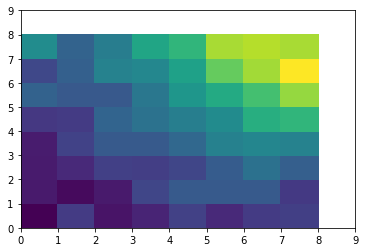

In [236]:
plt.pcolormesh(pcobs.T)

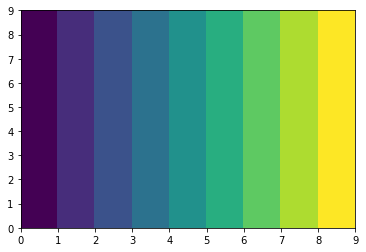

In [237]:
plt.pcolormesh(shearscat.T)

2.4037490384623874
0.7317607050787815


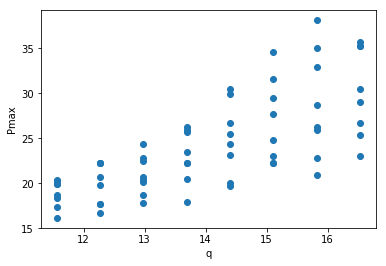

In [238]:
qscat = np.repeat(qbinso[np.newaxis,:],pcobs.shape[0],axis=0).reshape(pcobs.shape)
plt.scatter(qscat, pcobs)
plt.xlabel('q')
plt.ylabel('Pmax')
qfin = qscat[np.isfinite(pcobs)]
pfin = pcobs[np.isfinite(pcobs)]
qslope, qintercept, qr_value, qp_value, qstd_err = stats.linregress(qfin, pfin)
print(qslope)
print(qr_value)

In [239]:
deltaPQ = []
deltaQPQ = []
boxplotq = []
tminboxq = []
for qr in np.unique(qscat):
        
        vals = pcobs[qr==qscat]
        tvals = cpobsperc[qr==qscat]
        deltaPQ.append(np.nanmax(vals)-np.nanmin(vals))
        try:
            deltaQPQ.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
        except:
            deltaQPQ.append(np.nan)
        boxplotq.append(vals)
        tminboxq.append(tvals)
print(np.median(np.array(deltaQPQ)[np.isfinite(np.array(deltaQPQ))]))

4.864800027057326


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':


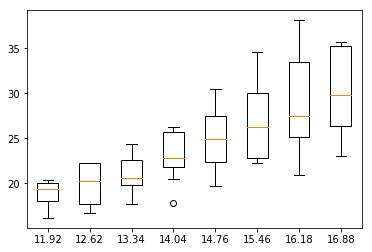

In [240]:
coll = []
qcollbins = np.round(np.unique(qscat),2)
qcollbins = np.round(qcollbins[0:-1]+((qcollbins[1::]-qcollbins[0:-1])/2),2)
for b in boxplotq:
    coll.append(b[np.isfinite(b)])
ax = plt.boxplot(coll[0:-1], labels=qcollbins, whis=1)
box2= (coll[0:-1],qcollbins)

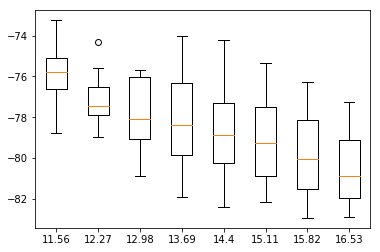

In [241]:
coll = []
for b in tminboxq:
    coll.append(b[b!=0])
ax = plt.boxplot(coll[0:-1], labels=np.round(np.unique(qscat),2)[0:-1])

In [242]:
print(qslope)
print(slope)

2.4037490384623874
0.5129639336519279


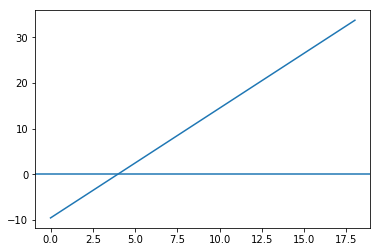

In [243]:
plt.plot(qintercept+qslope*range(19))
plt.axhline(0)

In [244]:
sensitivity = {}
sensitivity['shear_slope'] = slope
sensitivity['qslope'] = qslope 
pkl.dump(sensitivity, open(cnst.CLOVER_SAVES + 'q_shear_sensitivity_slopes', 'wb'))

In [245]:
data_list = [tmin_dic_obs, tmin_dic_cp4, tmin_dic_p25,prcp_dic_obs, prcp_dic_cp4, prcp_dic_p25]

0
1
2
3
4
5


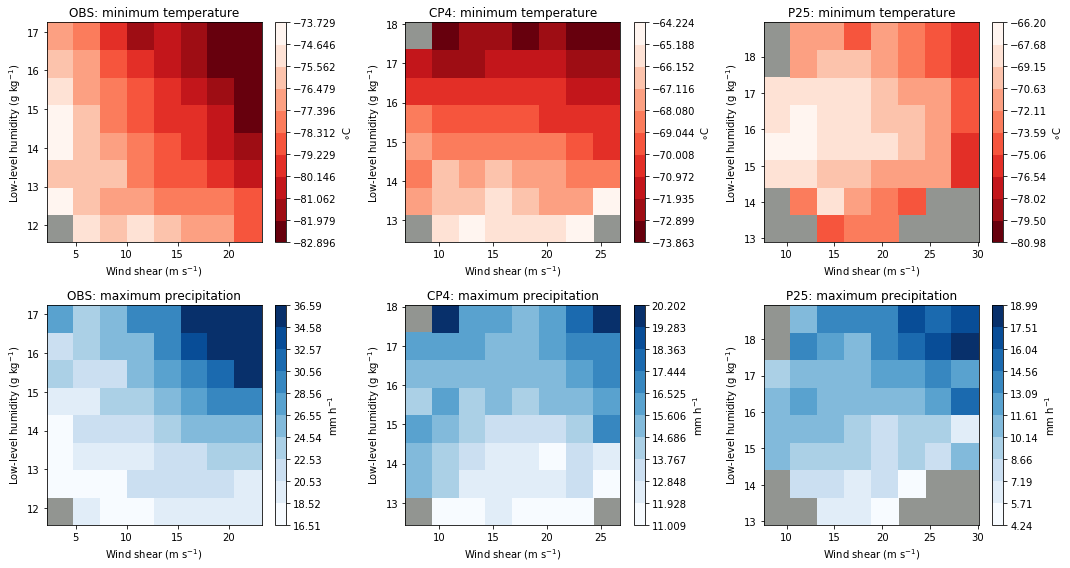

In [246]:
hist2d_six(data_list, valid=True)

##### 

In [247]:
data_list = [tmin_dic_obs, tmin_dic_cp4, area_dic,prcp_dic_obs, prcp_dic_cp4, area_dic_cp4]

0
1
2
3
4
5


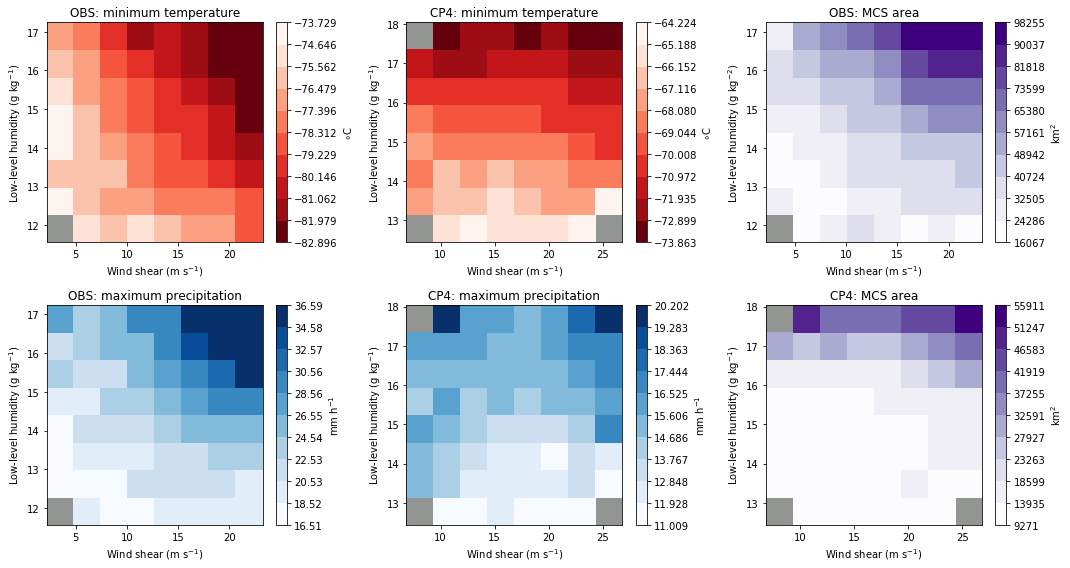

In [248]:
hist2d_six_area(data_list, valid=True)

In [249]:
data_list = [thetatmin_dic_obs, thetatmin_dic_cp4, thetaprcp_dic_obs, thetaprcp_dic_cp4]

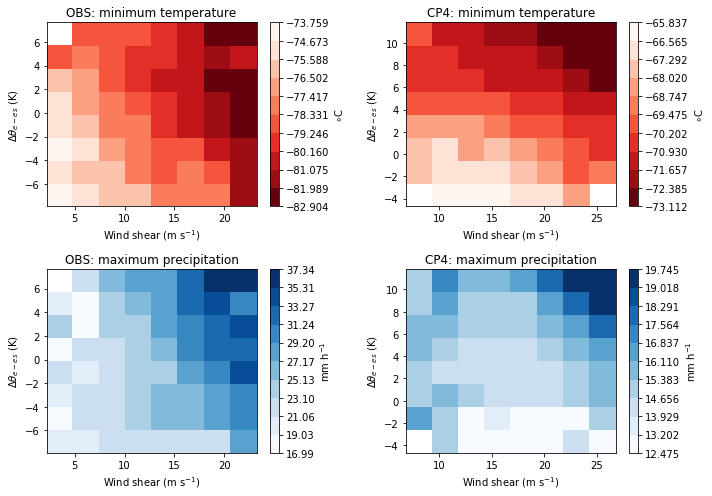

In [250]:
hist2d_quatro(data_list, valid=True)

In [195]:
data_list = [qtmin_dic_obs, qtmin_dic_cp4, qtprcp_dic_obs, qtprcp_dic_cp4]

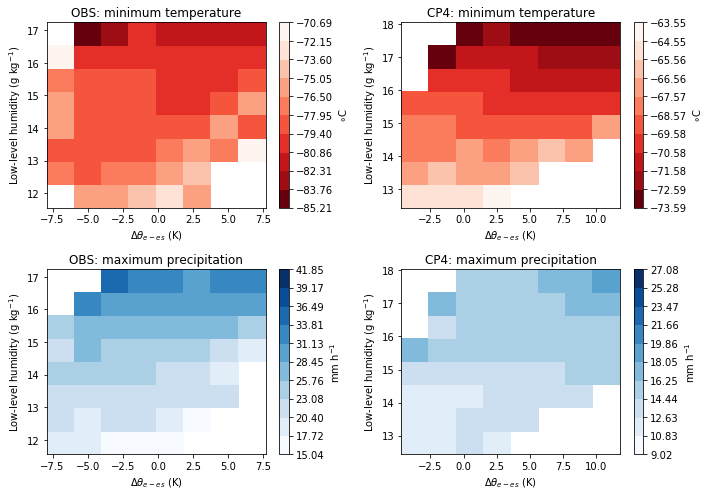

In [1959]:
hist2d_quatro(data_list, valid=True)